In [160]:
from skimage import data
from skimage import util
from skimage.io import imshow, imsave
import numpy as np
#rbg to channels:
img = util.img_as_ubyte(data.astronaut())

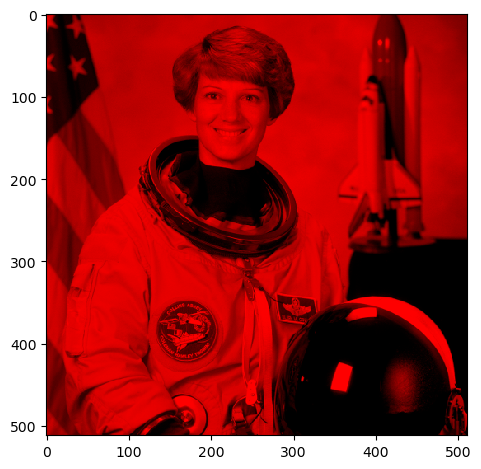

In [185]:
#функция на получение значения определенного канала изображения ( 0 - красный, 1 - зеленый, 2 - синий )
def get_channel_without_slice(img,channel=0):
    return img[:,:,:] * [channel==0,channel==1,channel==2]
def get_channel(img,channel=0):
    return img[:,:,channel]
def get_grayscale(img):
    gimg = (0.07 * img[:,:,2] + 0.72 * img[:,:,1] + 0.21 * img[:,:,0])
    # print(gimg.max(), gimg.min())
    return gimg
# get_grayscale(img)
# imshow(get_grayscale(img))
# imshow(get_channel(img,2))
imshow((get_channel_without_slice(img,0)))
#специально помечает именно интенсивность пикселей, а не выводит ЧБ вариант, видно на сохранении
# imsave("images/output_examples/31_10_2023.jpg", get_grayscale(get_channel_without_slice(img,2)))
# imshow(get_grayscale(get_channel(img,2)))

(512, 512)


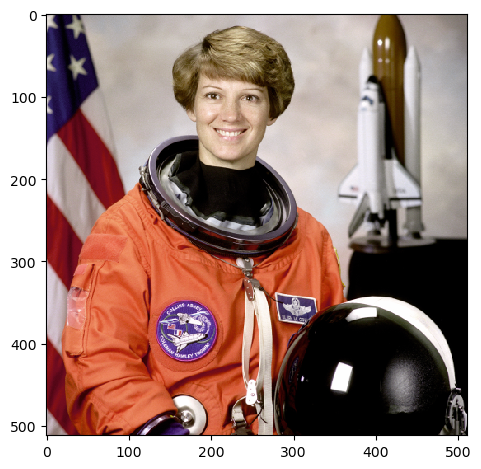

In [162]:
#восстановить из ЧБ
def restore_by_grayscale(r,g,b):
    print(r.shape)
    # restored = np.zeros((r.shape[0],r.shape[1],3))
    # restored[:,:] =  r[:,:]/0.07 
    # print(restored.shape, restored[:,:,0])
    # restored[:,:,1] =  g[:,:]/0.72
    # restored[:,:,2] =  b[:,:]/0.21
    restored = np.array([r[:,:], g[:,:], b[:,:]])
    # print(restored)
    restored = restored.swapaxes(0, 1)
    restored = restored.swapaxes(1, 2)
    # print(restored)
    return restored
r = get_channel(img,0)
g = get_channel(img,1)
b = get_channel(img,2)
restored = restore_by_grayscale(r,g,b)
# print(restored)
# print(restored.max(),restored.min())
imshow(restored)

In [163]:
#интерполирует значение функции в точке (x,y) по соседям
def bilinear_interpolate(im, x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    
    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1
    print(x0, x1, y0, y1)

    x0 = np.clip(x0, 0, im.shape[1]-1);
    x1 = np.clip(x1, 0, im.shape[1]-1);
    y0 = np.clip(y0, 0, im.shape[0]-1);
    y1 = np.clip(y1, 0, im.shape[0]-1);
    print(x0, x1, y0, y1)

    Ia = im[ y0, x0 ]
    Ib = im[ y1, x0 ]
    Ic = im[ y0, x1 ]
    Id = im[ y1, x1 ]
    print(Ia, Ib, Ic, Id)

    wa = (x1-x) * (y1-y)
    wb = (x1-x) * (y-y0)
    wc = (x-x0) * (y1-y)
    wd = (x-x0) * (y-y0)

    return wa*Ia + wb*Ib + wc*Ic + wd*Id

# bi = bilinear_interpolate(img,50, 60)
# bi



# imshow(bi)

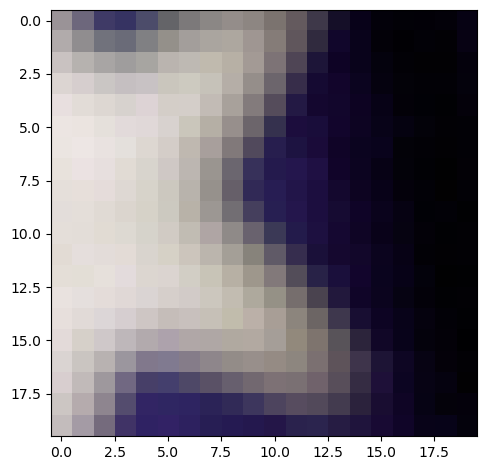

In [170]:
imshow(img[:20,:20,:])

In [168]:

import math
def u(s, a):
    if (abs(s) >= 0) & (abs(s) <= 1):
        return (a+2)*(abs(s)**3)-(a+3)*(abs(s)**2)+1
    elif (abs(s) > 1) & (abs(s) <= 2):
        return a*(abs(s)**3)-(5*a)*(abs(s)**2)+(8*a)*abs(s)-4*a
    return 0
  
  
# Padding
def padding(img, H, W, C):
    zimg = np.zeros((H+4, W+4, C))
    zimg[2:H+2, 2:W+2, :C] = img
      
    # Pad the first/last two col and row
    zimg[2:H+2, 0:2, :C] = img[:, 0:1, :C]
    zimg[H+2:H+4, 2:W+2, :] = img[H-1:H, :, :]
    zimg[2:H+2, W+2:W+4, :] = img[:, W-1:W, :]
    zimg[0:2, 2:W+2, :C] = img[0:1, :, :C]
      
    # Pad the missing eight points
    zimg[0:2, 0:2, :C] = img[0, 0, :C]
    zimg[H+2:H+4, 0:2, :C] = img[H-1, 0, :C]
    zimg[H+2:H+4, W+2:W+4, :C] = img[H-1, W-1, :C]
    zimg[0:2, W+2:W+4, :C] = img[0, W-1, :C]
    return zimg
  
  
# Bicubic operation
def bicubic(img, ratio, a):
    
    # Get image size
    H, W, C = img.shape
      
    # Here H = Height, W = weight,
    # C = Number of channels if the 
    # image is coloured.
    img = padding(img, H, W, C)
      
    # Create new image
    dH = math.floor(H*ratio)
    dW = math.floor(W*ratio)
  
    # Converting into matrix
    dst = np.zeros((dH, dW, 3))  
    # np.zeroes generates a matrix 
    # consisting only of zeroes
    # Here we initialize our answer 
    # (dst) as zero
  
    h = 1/ratio
  
    print('Start bicubic interpolation')
    print('It will take a little while...')
    inc = 0
      
    for c in range(C):
        for j in range(dH):
            for i in range(dW):
                
                # Getting the coordinates of the
                # nearby values
                x, y = i * h + 2, j * h + 2
  
                x1 = 1 + x - math.floor(x)
                x2 = x - math.floor(x)
                x3 = math.floor(x) + 1 - x
                x4 = math.floor(x) + 2 - x
  
                y1 = 1 + y - math.floor(y)
                y2 = y - math.floor(y)
                y3 = math.floor(y) + 1 - y
                y4 = math.floor(y) + 2 - y
                  
                # Considering all nearby 16 values
                mat_l = np.matrix([[u(x1, a), u(x2, a), u(x3, a), u(x4, a)]])
                mat_m = np.matrix([[img[int(y-y1), int(x-x1), c],
                                    img[int(y-y2), int(x-x1), c],
                                    img[int(y+y3), int(x-x1), c],
                                    img[int(y+y4), int(x-x1), c]],
                                   [img[int(y-y1), int(x-x2), c],
                                    img[int(y-y2), int(x-x2), c],
                                    img[int(y+y3), int(x-x2), c],
                                    img[int(y+y4), int(x-x2), c]],
                                   [img[int(y-y1), int(x+x3), c],
                                    img[int(y-y2), int(x+x3), c],
                                    img[int(y+y3), int(x+x3), c],
                                    img[int(y+y4), int(x+x3), c]],
                                   [img[int(y-y1), int(x+x4), c],
                                    img[int(y-y2), int(x+x4), c],
                                    img[int(y+y3), int(x+x4), c],
                                    img[int(y+y4), int(x+x4), c]]])
                mat_r = np.matrix(
                    [[u(y1, a)], [u(y2, a)], [u(y3, a)], [u(y4, a)]])
                  
                # Here the dot function is used to get 
                # the dot product of 2 matrices
                dst[j, i, c] = np.dot(np.dot(mat_l, mat_m), mat_r)
  
    # If there is an error message, it
    # directly goes to stderr
      
    # Flushing the buffer
    return dst
  
  
# Read image
# You can put your input image over 
# here to run bicubic interpolation
# The read function of Open CV is used
# for this task
  
# Scale factor
ratio = 2
# Coefficient
a = -1/2
  
# Passing the input image in the 
# bicubic function
H, W, C = img.shape
padded = padding(img,H, W, C)
# imshow(padded.astype(int)[:3,:,:]) 
dst = bicubic(img[:20,:20,:], ratio, a)
print('Completed!')

Start bicubic interpolation
It will take a little while...
Completed!


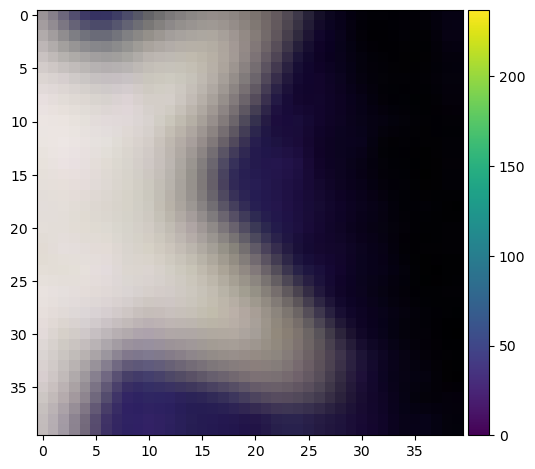

In [169]:
imshow(dst.astype(int))

In [171]:
#bilinear
def bilinear_interpolation(src, dst_shape):
    # Get Original Dimension
    src_height, src_width = src.shape[0], src.shape[1]
    # Calculate New Graph Dimensions
    dst_height, dst_width, channels = dst_shape[0], dst_shape[1], dst_shape[2]
    
    dst = np.zeros(shape = (dst_height, dst_width, channels), dtype=np.uint8)
    for dst_x in range(dst_height):
        for dst_y in range(dst_width):
            # Finding the corresponding coordinates of the source image
            src_x = (dst_x+0.5) * (src_width/dst_width) - 0.5
            src_y = (dst_y+0.5) * (src_width/dst_width) - 0.5
            
            # Calculate Interpolation
            i, j = int(src_x), int(src_y)
            u, v = src_x - i, src_y - j
            f = (1-u)*(1-v)*src[i,j] + (1-u)*v*src[i,j+1] + u*(1-v)*src[i+1,j] + u*v*src[i+1,j+1]
            f = np.clip(f, 0, 255)   # Handle data that is out of bounds

            # interpolation
            dst[dst_x, dst_y,:] = f.astype(np.uint8)
    return dst

In [177]:
imshow(img[:20,:20,:], [40,40,3])

TypeError: unhashable type: 'list'